In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

# use grid_2d_graph to generate the basic graph to optimize things on
def generate_graph(nb_nodes_x = 10, 
                   nb_nodes_y=5, 
                   total_demand=3, 
                   max_weight=10, 
                   max_uncertainty=10, 
                   max_capacity=3):

    G = nx.grid_2d_graph(nb_nodes_x, nb_nodes_y)

    # create a directed version of this graph
    Gdir = nx.DiGraph()
    # copy the nodes
    Gdir.add_nodes_from(G.nodes)
    # import the arcs and see them only as one-way arcs
    Gdir.add_edges_from(G.edges)
    # positions dictionary
    positions = {x : (10*x[0], 2 * x[1]) for x in Gdir.nodes} # positions dictionary

    #nx.draw(Gdir, pos = positions)

    # define the demands: -2 at the top left node and +2 at the top right node
    for node in Gdir.nodes:
        if node == (0, 0):
            Gdir.nodes[node]["demand"] = -total_demand
        elif node == (nb_nodes_x-1, nb_nodes_y-1):
            Gdir.nodes[node]["demand"] = total_demand
        else:
            Gdir.nodes[node]["demand"] = 0

    for edge in Gdir.edges:
        Gdir.edges[edge]["weight"] = np.ceil(np.random.rand() * max_weight)
        Gdir.edges[edge]["capacity"] = np.ceil(np.random.rand() * max_capacity)
        Gdir.edges[edge]["perturbation"] = np.ceil(np.random.rand() * max_uncertainty)
        
    return Gdir

def draw_solution(Gdir, mc_flow_per_edge, color_used = "r", axis = None, edge_width=1):
    positions = {x : (10*x[0], 2 * x[1]) for x in Gdir.nodes} # positions dictionary
    G_max_flow = nx.DiGraph()
    G_max_flow.add_nodes_from(Gdir.nodes)
    G_max_flow.add_edges_from([(x, y) for
                               (x, y) in mc_flow_per_edge.keys() if
                               np.round(mc_flow_per_edge[(x, y)]) > 0])

    # set the colors of the edges to red
    for edge in G_max_flow.edges:
        G_max_flow.edges[edge]["color"] = color_used
    
    plt.figure(1, figsize = (20, 10))
    #nx.draw(Gdir,  pos = positions)
    
    if axis is None:
        nx.draw(G_max_flow, 
                pos = positions, 
                edge_color = nx.get_edge_attributes(G_max_flow,'color').values(),
                width = edge_width)
    else:
        nx.draw(G_max_flow, 
                pos = positions, 
                edge_color = nx.get_edge_attributes(G_max_flow,'color').values(),
                width = edge_width,
                ax = axis)

def solve_robust_max_flow(Gdir, uncertainty_budget=0):
    m = pyo.ConcreteModel()

    m.edges = pyo.Set(initialize=[x for x in Gdir.edges])
    max_capacity = max([Gdir.edges[edge]["capacity"] for edge in Gdir.edges])
    m.flows = pyo.Var(m.edges, domain=pyo.NonNegativeIntegers, bounds=(0, max_capacity))
    m.s = pyo.Var(m.edges, domain=pyo.NonNegativeReals, bounds=(0, max_capacity))
    m.lam = pyo.Var(domain=pyo.NonNegativeReals)

    m.constraints = pyo.ConstraintList()

    # balance equations
    for node in Gdir.nodes:
        successors = list(Gdir.successors(node))
        predecessors = list(Gdir.predecessors(node))
        

        # inflow minus outflow equals demand
        m.constraints.add(pyo.quicksum(m.flows[(pred, node)] for pred in predecessors) - 
                          pyo.quicksum(m.flows[(node, succ)] for succ in successors) ==
                          Gdir.nodes[node]["demand"])
        
    for (x, y) in Gdir.edges:
        # capacity constraint
        m.constraints.add(m.flows[(x, y)] <= Gdir.edges[(x, y)]["capacity"])
        
        # robustness proxy in the objective
        m.constraints.add(m.s[(x, y)] >= m.flows[(x, y)] * Gdir.edges[(x, y)]["perturbation"] - m.lam)
        
        # m.s is an upper bound on perturbation

    m.obj = pyo.Objective(expr = pyo.quicksum(m.flows[(x, y)] * Gdir.edges[(x, y)]["weight"] 
                                              for (x, y) in Gdir.edges) +
                                 m.lam * uncertainty_budget +
                                 pyo.quicksum(m.s[(x, y)] for (x, y) in Gdir.edges),
                          sense = pyo.minimize)

    solver = pyo.SolverFactory('gurobi')
    solver.solve(m)

    solution = {(x, y) : m.flows[(x, y)]()
                        for (x, y) in Gdir.edges}

    return solution, m.obj()


def simulate_flow_cost(Gdir, 
                       solution, 
                       N_sim = 1000, 
                       p = 0.5):
    sim_costs = []
    
    for i_simulation in range(N_sim):
        Cost = sum([solution[(x, y)] * 
                    (Gdir.edges[(x, y)]["weight"] + 
                     (np.random.rand() >= 1 - p) * Gdir.edges[(x, y)]["perturbation"])
                   for (x, y) in Gdir.edges])
        sim_costs.append(Cost)
    
    quantiles = [np.quantile(sim_costs, q) for q in np.arange(0.1, 1, 0.1)]
    return np.average(sim_costs), quantiles

def evaluate_worst_cost(Gdir, solution, unc_budget = 0):
    m = pyo.ConcreteModel()
    m.edges = pyo.Set(initialize=[x for x in Gdir.edges])
    m.z = pyo.Var(m.edges, domain=pyo.NonNegativeReals, bounds=(0, 1))
    m.constraints = pyo.ConstraintList()
    
    # uncertainty budget
    m.constraints.add(pyo.quicksum(m.z[(x, y)] for (x, y) in Gdir.edges) <= unc_budget)

    m.obj = pyo.Objective(expr = pyo.quicksum(solution[(x, y)] * (Gdir.edges[(x, y)]["weight"] + 
                                                                  m.z[(x, y)] * Gdir.edges[(x, y)]["perturbation"])
                                              for (x, y) in Gdir.edges),
                          sense = pyo.maximize)

    solver = pyo.SolverFactory('gurobi')
    results = solver.solve(m)
    return m.obj()



Bad key "text.kerning_factor" on line 4 in
C:\Programs\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [10]:
N_attempts = 1000
nice_instances = [260]#30, 79, 137, 260, 494, 513, 605, 712, 870, 923, 960]
max_budget = 10

for i_attempt in nice_instances:
    print(f"Instance: {i_attempt}")
    np.random.seed(i_attempt)
    
    Gdir = generate_graph(nb_nodes_x =6, 
                   nb_nodes_y=6, 
                   total_demand=2, 
                   max_weight=5, 
                   max_uncertainty=5, 
                   max_capacity=1)
    
    optvals = []
    simvals = []
    worstvals = []
    max_budget = 10
    try:
        for unc_budget in np.arange(0, max_budget, 1):
            solution, optval = solve_robust_max_flow(Gdir, unc_budget)
            prob = max_budget / len(Gdir.edges)
            simcost, quantiles = simulate_flow_cost(Gdir, solution, 100, prob)
            worst_case = evaluate_worst_cost(Gdir, solution, max_budget)
            optvals.append(optval)
            simvals.append(simcost)
            worstvals.append(worst_case)
            #print(f"Uncertainty budget: {unc_budget}, optimal value: {optval} {worst_case}, simulated cost: {simcost:5.2f}")
        if min(simvals) < 0.95*simvals[0]:
            print(f"Good instance: {i_attempt}")
            #nice_instances.append(i_attempt)
            print(optvals, " ", simvals, " ", worstvals)
    except:
        print("Some error")

Instance: 260
Good instance: 260
[43.0, 47.0, 51.0, 55.0, 59.0, 62.0, 65.0, 68.0, 71.0, 74.0]   [53.05, 50.64, 49.35, 51.17, 49.68, 50.81, 50.51, 50.54, 50.09, 50.32]   [83.0, 74.0, 74.0, 74.0, 74.0, 72.0, 74.0, 74.0, 74.0, 74.0]


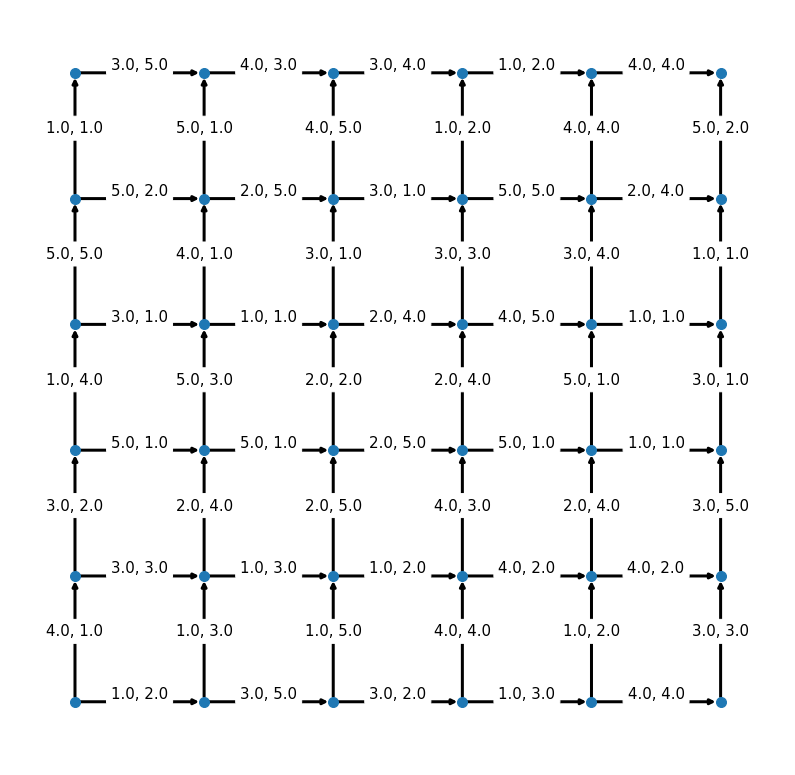

In [9]:
# This is a code snippet for plotting the network for the slides

N_attempts = 1000
i_attempt = 260#30, 79, 137, 260, 494, 513, 605, 712, 870, 923, 960]
max_budget = 10
np.random.seed(i_attempt)
Gdir = generate_graph(nb_nodes_x =6, 
                   nb_nodes_y=6, 
                   total_demand=2, 
                   max_weight=5, 
                   max_uncertainty=5, 
                   max_capacity=1)

# node positions
positions = {x : (10*x[0], 2 * x[1]) for x in Gdir.nodes}

# define the optimal plot
fig, axes = plt.subplots(1, 1, figsize = (14, 14))

# first plot - the state of the network
nx.draw_networkx(Gdir, pos=positions, ax = axes, width = 3, node_size = 100, with_labels = False)
weights = nx.get_edge_attributes(Gdir,'weight')
perturbations = nx.get_edge_attributes(Gdir,'perturbation')
labels = {x: f"{weights[x]}, {perturbations[x]}" for x in weights}

nx.draw_networkx_edge_labels(Gdir, 
                             pos=positions,
                             edge_labels=labels, 
                             ax = axes,
                             font_size = 15,
                             horizontalalignment = 'center',
                             verticalalignment = 'bottom',
                             rotate = False)
axes.axis("off")
plt.savefig("Network_problem.eps")

# # second plot, the nominal solution drawn
# unc_budget = 0
# solution, optval = solve_robust_max_flow(Gdir, unc_budget)
# draw_solution(Gdir, solution, "red", axes[1], 3)
# print(optval)
# worst_case = evaluate_worst_cost(Gdir, solution, max_budget)
# print(worst_case)

# plt.savefig("Network_problem.png")

In [15]:
optvals = []
simvals = []
worstvals = []

for unc_budget in np.arange(0, 10, 1):
    solution, optval = solve_robust_max_flow(Gdir, unc_budget)
    
    prob = max_budget / len(Gdir.edges)
    simcost, quantiles = simulate_flow_cost(Gdir, solution, 100, prob)
    worst_case = evaluate_worst_cost(Gdir, solution, max_budget)
    optvals.append(optval)
    simvals.append(simcost)
    worstvals.append(worst_case)
    
print(optvals)
print(simvals)
print(worstvals)

[43.0, 47.0, 51.0, 55.0, 59.0, 62.0, 65.0, 68.0, 71.0, 74.0]
[53.05, 50.64, 49.35, 51.17, 49.68, 50.81, 50.51, 50.54, 50.09, 50.32]
[83.0, 74.0, 74.0, 74.0, 74.0, 72.0, 74.0, 74.0, 74.0, 74.0]
